# greenland subglacial lake inventory

Investigate the inferred basal thermal conditions of RES-derived subglacial lakes

## Part 1: By visual inspection

Plot subglacial lakes, coloured by the type of observation used to inventory the lake, overlaid on a map of inferred basal thermal state.

Note here the constant `agree_threshold` sets the number of models (out of 10) that need to agree that the basal thermal state is frozen/thawed for us to use that classification. The Jakobshavn lakes have 4/10 models predict a warm bed, while the northern Greenland lakes have 2 models predicting a warm bed. All other lakes are modelled as cold-based.

In [1]:
# File path manipulation
import os

# Reading shapefiles and handle projections
import fiona
from pyproj import Proj, transform, Transformer
from shapely.geometry import shape

# General plotting
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.gridspec import GridSpec
import cmocean
import numpy as np

# Data management
import pandas as pd
import netCDF4 as nc
from IPython.display import display, Markdown

agree_threshold = 3

## Basal thermal state

Read likely basal thermal state and model agreement data

In [2]:
greenland_thermal_dir = '../../data/raw/greenland_basal_thermal_state/'
greenland_thermal_file = 'RDBTS4_Greenland_1993_2017_02_basal_thermal_state.nc'
greenland_thermal_path = os.path.join(greenland_thermal_dir, greenland_thermal_file)

with nc.Dataset(greenland_thermal_path) as greenland_thermal_data:
    x = greenland_thermal_data['x'][:].data
    y = greenland_thermal_data['y'][:].data
    likely_state = greenland_thermal_data['likely_basal_thermal_state'][:].data
    agreement_warm = greenland_thermal_data['agreement_ismip6_warm'][:].data
    agreement = greenland_thermal_data['agreement_ismip6'][:].data
    agreement_cold = greenland_thermal_data['agreement_ismip6_cold'][:].data
    

### Subglacial lake inventory

Subglacial lake inventory from [Livingstone et al. (2022)](https://doi.org/10.1038/s43017-021-00246-9), with an additional field to declare the type of observation.

Legend:

Label | Observation type
----- | ----------------
  0   |  Active lake
  1   |  RES only
  2   |  RES with flat ice surface
  3   |  Seismic
  4   |  Drilled

In [3]:
# Read raw data and coordinate projection
greenland_lake_file = os.path.join('../../data/raw/lakes/','43017_2021_246_MOESM1_ESM_SK_TH_Greenland.csv')
greenland_obstype = np.loadtxt(greenland_lake_file, skiprows=1, delimiter=',', dtype=int, usecols=(3,), comments=None)
greenland_latlon = np.loadtxt(greenland_lake_file, skiprows=1, delimiter=',', dtype=str, usecols=(1,2), comments=None)
greenland_conf = np.loadtxt(greenland_lake_file, skiprows=1, delimiter=',', dtype=str, usecols=8, comments=None)

# No confidence for active lakes
greenland_conf[:7] = ''

# Parse latlon to xy coordinates
src_crs = Proj('EPSG:4326') # WGS84
# prj_crs = Proj(ps_proj) # greenland polar stereographic
prj_crs = Proj('EPSG:3413')
transformer = Transformer.from_proj(src_crs, prj_crs)
greenland_xy = np.zeros(greenland_latlon.shape, dtype=float)
for i,xy in enumerate(greenland_latlon):
    try:
        greenland_xy[i] = transformer.transform(*xy.astype(float))
    except:
        greenland_xy[i] = np.nan

In [4]:
# Re-encode observation types

# Convert integer flags to string labels
obstype_str = np.zeros(greenland_obstype.shape, dtype='U8')
obstype_str[greenland_obstype==1] = 'RES_only'
obstype_str[greenland_obstype==2] = 'RES_flat'
obstype_str[greenland_obstype==3] = 'seismic'
obstype_str[greenland_obstype==4] = 'drilled'
obstype_str[greenland_obstype==0] = 'active'

# conf_int = np.zeros(greenland_conf.shape, dtype=int)
# conf_int[greenland_conf=='Low'] = 0
# conf_int[greenland_conf=='Medium'] = 1
# conf_int[greenland_conf=='High'] = 2
# conf_int[greenland_conf=='Very high'] = 3

# Convert to pd.DataFrame for nice summary printing
lakes_df = pd.DataFrame(
    data={'obs': obstype_str,
          'x': greenland_xy[:, 0],
          'y': greenland_xy[:, 1],
          'confidence':greenland_conf}
)



stable_lakes = lakes_df[lakes_df['obs']!='active']

In [5]:
display(Markdown('### All lakes (stable + active)'))

display(Markdown('**Counts**'))
lakes_df['obs'].value_counts(normalize=False)

### All lakes (stable + active)

**Counts**

obs
RES_only    55
active       8
seismic      1
Name: count, dtype: int64

In [6]:
display(Markdown('### Stable lakes'))
stable_lakes.head()

### Stable lakes

,obs,x,y,confidence
1,seismic,-517738.504199,-1.196769e+06,
2,RES_only,-520265.051862,-1.199912e+06,
7,RES_only,-368362.686674,-1.341578e+06,Low
8,RES_only,-363617.078239,-1.342391e+06,High
9,RES_only,-402032.662535,-1.152602e+06,High


In [7]:
display(Markdown('**Counts**'))
print(stable_lakes['obs'].value_counts(normalize=False))

display(Markdown('**Normalized**'))
print(stable_lakes['obs'].value_counts(normalize=True))

**Counts**

obs
RES_only    55
seismic      1
Name: count, dtype: int64


**Normalized**

obs
RES_only    0.982143
seismic     0.017857
Name: proportion, dtype: float64


### Overlay lake positions and basal thermal state

In [8]:
# Scatter plot settings
colors = {
    'RES_only': '#d01616',
#     'RES_only': 'red',
    'RES_flat': '#ff00ff',
    'seismic' : '#00ffff',
}

edgecolors = {
    'RES_only':'w',
    'RES_flat':'k',
    'seismic':'k',
}


edgecolor = {
    'RES_only': 'k',
    'RES_flat': 'k',
    'seismic': 'k'
}

markers = {
    'RES_only': 'o',
    'RES_flat': '^',
    'seismic': 's',
}

size = {
    'RES_only': 50,
    'RES_flat': 50,
    'seismic': 100
}
labels = {'RES_only': 'RES only',
          'RES_flat': 'RES, flat',
          'seismic': 'Seismic',
          'drilled': 'Drilled',
         }

## Using M22 `likely_state`

Text(-380000.0, -3277500.0, '500 km')

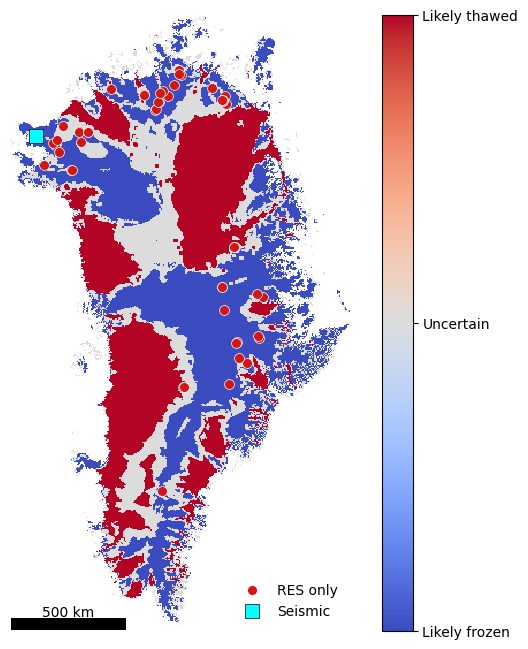

In [9]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='w')
[xx,yy] = np.meshgrid(x,y)
pc = ax.pcolormesh(xx, yy, likely_state, vmin=-1, vmax=1, cmap='coolwarm')
ax.set_aspect('equal')

cb = fig.colorbar(pc)
cb.set_ticks([-1, 0, 1])
cb.set_ticklabels(['Likely frozen', 'Uncertain', 'Likely thawed'])

lakes_categories = ['RES_only', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = lakes_df.where(lakes_df['obs']==category)
        ax.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolors[category],
                   linewidth=0.5, label=labels[category],
                   marker=markers[category])

ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='lower right', frameon=False, markerscale=1)

xmin = min(x)
ymin = min(y)
scale_width = 500e3
scale_height = 0.1*scale_width
scalebar = patches.Rectangle((xmin, ymin), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(xmin + 0.5*scale_width, ymin + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')



### Using thresholded model agreement

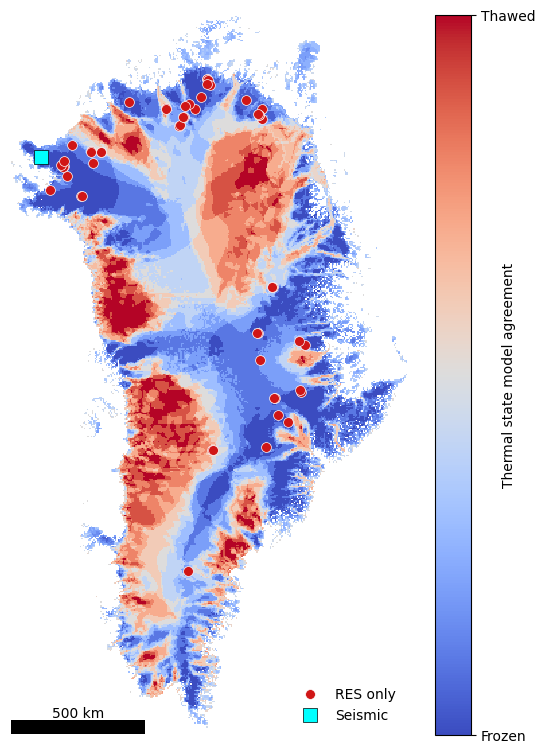

In [10]:
fig, ax = plt.subplots(figsize=(6, 8), facecolor='w')
[xx,yy] = np.meshgrid(x,y)
pc = ax.pcolormesh(xx, yy, agreement/10, cmap='coolwarm')
ax.set_aspect('equal')

cb = fig.colorbar(pc)
cb.set_label('Thermal state model agreement', labelpad=-24)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Frozen', 'Thawed'])
# cb.set_ticks([-1, 0, 1])
# cb.set_ticklabels(['Likely frozen', 'Uncertain', 'Likely thawed'])

lakes_categories = ['RES_only', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = lakes_df.where(lakes_df['obs']==category)
        ax.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolors[category], linewidth=0.5, label=labels[category],
                  marker=markers[category])

ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='lower right', frameon=False, markerscale=1)

xmin = min(x)
ymin = min(y)
scale_width = 500e3
scale_height = 0.1*scale_width
scalebar = patches.Rectangle((xmin, ymin), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(xmin + 0.5*scale_width, ymin + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')

fig.subplots_adjust(left=0.0, bottom=0.05, right=0.9, top=0.95)
fig.savefig('greenland_thermal_lakes.png', dpi=600)


### Show change in agreement level between warm- and cold-bias thresholds

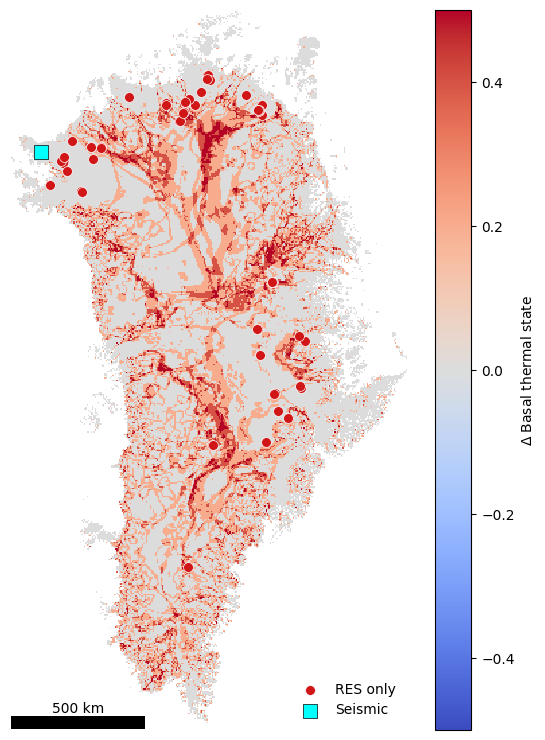

In [11]:
fig, ax = plt.subplots(figsize=(6, 8))
[xx,yy] = np.meshgrid(x,y)
pc = ax.pcolormesh(xx, yy, (agreement_warm - agreement_cold)/10, cmap='coolwarm', vmin=-0.5, vmax=0.5)
ax.set_aspect('equal')

cb = fig.colorbar(pc)
cb.set_label(r'$\Delta$ Basal thermal state')

lakes_categories = ['RES_only', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = lakes_df.where(lakes_df['obs']==category)
        ax.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolors[category], linewidth=0.5, label=labels[category],
                  marker=markers[category])

ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='lower right', frameon=False, markerscale=1)

xmin = min(x)
ymin = min(y)
scale_width = 500e3
scale_height = 0.1*scale_width
scalebar = patches.Rectangle((xmin, ymin), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(xmin + 0.5*scale_width, ymin + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')

fig.subplots_adjust(left=0.0, bottom=0.05, right=0.9, top=0.95)
# fig.savefig('greenland_thermal_lakes.png', dpi=600)


## Part 2: Analysis

Extract the inferred basal temperature for each subglacial lake position


In [12]:
import scipy.interpolate

points = (y, x)
xq = stable_lakes[['y', 'x']].to_numpy()

lake_agree = scipy.interpolate.interpn(points, agreement, xq, bounds_error=False, fill_value=np.nan, method='nearest')
lake_agree_warm = scipy.interpolate.interpn(points, agreement_warm, xq, bounds_error=False, fill_value=np.nan, method='nearest')
lake_agree_cold = scipy.interpolate.interpn(points, agreement_cold, xq, bounds_error=False, fill_value=np.nan, method='nearest')
# lake_state= scipy.interpolate.interpn(points, likely_state, xq, bounds_error=False, fill_value=np.nan, method='nearest')

stable_lakes.loc[:,'Agreement'] = lake_agree
stable_lakes.loc[:,'Agreement_warm'] = lake_agree_warm
stable_lakes.loc[:,'Agreement_cold'] = lake_agree_cold
# stable_lakes['Likely state'] = lake_state
# stable_lakes['Likely state'] = stable_lakes['Likely state'].astype('category')

bins = (-10.5, -agree_threshold-0.5, agree_threshold+0.5, 10.5)
stable_lakes.loc[:, 'Tm_cat'] = pd.cut(stable_lakes['Agreement'], bins=bins, labels=('Cold', 'Uncertain', 'Thawed'))
stable_lakes.loc[:,'Tm_warmBias'] = pd.cut(stable_lakes['Agreement_warm'], bins=bins, labels=('Cold', 'Uncertain', 'Thawed'))
stable_lakes.loc[:,'Tm_coldBias'] = pd.cut(stable_lakes['Agreement_cold'], bins=bins, labels=('Cold', 'Uncertain', 'Thawed'))
stable_lakes.head()

/tmp/ipykernel_14577/1761630900.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable_lakes.loc[:,'Agreement'] = lake_agree
/tmp/ipykernel_14577/1761630900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable_lakes.loc[:,'Agreement_warm'] = lake_agree_warm
/tmp/ipykernel_14577/1761630900.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,obs,x,y,confidence,Agreement,Agreement_warm,Agreement_cold,Tm_cat,Tm_warmBias,Tm_coldBias
1,seismic,-517738.504199,-1.196769e+06,,-9.0,-9.0,-9.0,Cold,Cold,Cold
2,RES_only,-520265.051862,-1.199912e+06,,-9.0,-9.0,-9.0,Cold,Cold,Cold
7,RES_only,-368362.686674,-1.341578e+06,Low,-10.0,-10.0,-10.0,Cold,Cold,Cold
8,RES_only,-363617.078239,-1.342391e+06,High,-10.0,-10.0,-10.0,Cold,Cold,Cold
9,RES_only,-402032.662535,-1.152602e+06,High,-8.0,-8.0,-8.0,Cold,Cold,Cold


### Extract RES_only, RES_flat, RES_only+RES_flat, and seismic lake classifications

In [13]:
RES_only_lakes = stable_lakes[stable_lakes['obs']=='RES_only']
RES_flat_lakes = stable_lakes[stable_lakes['obs']=='RES_flat']
RES_lakes = stable_lakes[stable_lakes['obs']!='seismic']
seismic_lakes = stable_lakes[stable_lakes['obs']=='seismic']

### Basal temperature agreement of RES_flat and seismic lakes

In [14]:
RES_flat_lakes

,obs,x,y,confidence,Agreement,Agreement_warm,Agreement_cold,Tm_cat,Tm_warmBias,Tm_coldBias


In [15]:
seismic_lakes

,obs,x,y,confidence,Agreement,Agreement_warm,Agreement_cold,Tm_cat,Tm_warmBias,Tm_coldBias
1,seismic,-517738.504199,-1.196769e+06,,-9.0,-9.0,-9.0,Cold,Cold,Cold


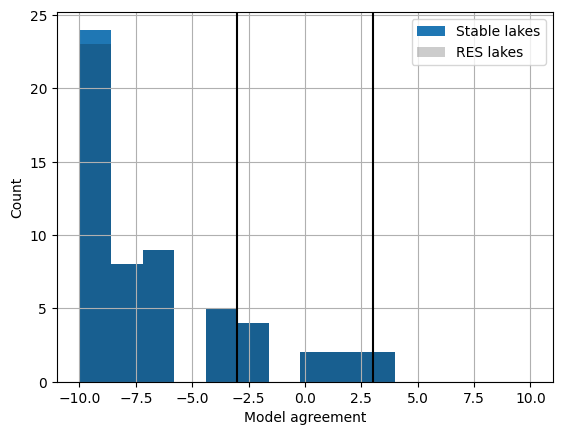

In [16]:
fig, ax = plt.subplots()
ax.hist(stable_lakes['Agreement'], label='Stable lakes')

ax.hist(RES_lakes['Agreement'], label='RES lakes', facecolor='k', alpha=0.2)
ax.set_xlabel('Model agreement')
ax.set_ylabel('Count')
ax.axvline(-3, color='k')
ax.axvline(3, color='k')
ax.set_xlim([-11, 11])
ax.legend()
ax.grid()

### Tables

Print the number and proportion of stable and RES lakes in each basal state. For now, use both our own thresholding on the model agreement field and the provided likely basal thermal state map

#### All stable lakes

In [17]:
display(Markdown('## Standard Threshold'))

display(Markdown('**Counts**'))
print(stable_lakes['Tm_cat'].value_counts(normalize=False))

display(Markdown('**Normalized**'))
print(stable_lakes['Tm_cat'].value_counts(normalize=True))

display(Markdown('## Warm Bias'))
display(Markdown('**Counts**'))
print(stable_lakes['Tm_warmBias'].value_counts(normalize=False))
display(Markdown('**Normalized**'))
print(stable_lakes['Tm_warmBias'].value_counts(normalize=True))

display(Markdown('## Cold Bias'))
display(Markdown('**Counts**'))
print(stable_lakes['Tm_coldBias'].value_counts(normalize=False))
display(Markdown('**Normalized**'))
print(stable_lakes['Tm_coldBias'].value_counts(normalize=True))


## Standard Threshold

**Counts**

Tm_cat
Cold         46
Uncertain     8
Thawed        2
Name: count, dtype: int64


**Normalized**

Tm_cat
Cold         0.821429
Uncertain    0.142857
Thawed       0.035714
Name: proportion, dtype: float64


## Warm Bias

**Counts**

Tm_warmBias
Cold         43
Uncertain    11
Thawed        2
Name: count, dtype: int64


**Normalized**

Tm_warmBias
Cold         0.767857
Uncertain    0.196429
Thawed       0.035714
Name: proportion, dtype: float64


## Cold Bias

**Counts**

Tm_coldBias
Cold         49
Uncertain     5
Thawed        2
Name: count, dtype: int64


**Normalized**

Tm_coldBias
Cold         0.875000
Uncertain    0.089286
Thawed       0.035714
Name: proportion, dtype: float64


### RES-only lakes

In [18]:
display(Markdown('## Standard Threshold'))

display(Markdown('**Counts**'))
print(RES_lakes['Tm_cat'].value_counts(normalize=False))

display(Markdown('**Normalized**'))
print(RES_lakes['Tm_cat'].value_counts(normalize=True))

display(Markdown('## Warm Bias'))
display(Markdown('**Counts**'))
print(RES_lakes['Tm_warmBias'].value_counts(normalize=False))
display(Markdown('**Normalized**'))
print(RES_lakes['Tm_warmBias'].value_counts(normalize=True))

display(Markdown('## Cold Bias'))
display(Markdown('**Counts**'))
print(RES_lakes['Tm_coldBias'].value_counts(normalize=False))
display(Markdown('**Normalized**'))
print(RES_lakes['Tm_coldBias'].value_counts(normalize=True))


## Standard Threshold

**Counts**

Tm_cat
Cold         45
Uncertain     8
Thawed        2
Name: count, dtype: int64


**Normalized**

Tm_cat
Cold         0.818182
Uncertain    0.145455
Thawed       0.036364
Name: proportion, dtype: float64


## Warm Bias

**Counts**

Tm_warmBias
Cold         42
Uncertain    11
Thawed        2
Name: count, dtype: int64


**Normalized**

Tm_warmBias
Cold         0.763636
Uncertain    0.200000
Thawed       0.036364
Name: proportion, dtype: float64


## Cold Bias

**Counts**

Tm_coldBias
Cold         48
Uncertain     5
Thawed        2
Name: count, dtype: int64


**Normalized**

Tm_coldBias
Cold         0.872727
Uncertain    0.090909
Thawed       0.036364
Name: proportion, dtype: float64


In [19]:
display(Markdown('## RES_only lakes confidence'))

display(Markdown('**Counts**'))
print(RES_only_lakes['confidence'].value_counts(normalize=False, sort=False))

display(Markdown('**Normalized**'))
print(RES_only_lakes['confidence'].value_counts(normalize=True, sort=False))


## RES_only lakes confidence

**Counts**

confidence
              1
Low           4
High         18
Very high     6
Medium       26
Name: count, dtype: int64


**Normalized**

confidence
             0.018182
Low          0.072727
High         0.327273
Very high    0.109091
Medium       0.472727
Name: proportion, dtype: float64


## Figures part 2

Plot basal thermal state model, with
 
 * Lakes coloured by basal thermal state, marker shapes by their observation type
 * Lakes coloured by Bowling et al. (2019) confidence level, marker shapes by their observation type

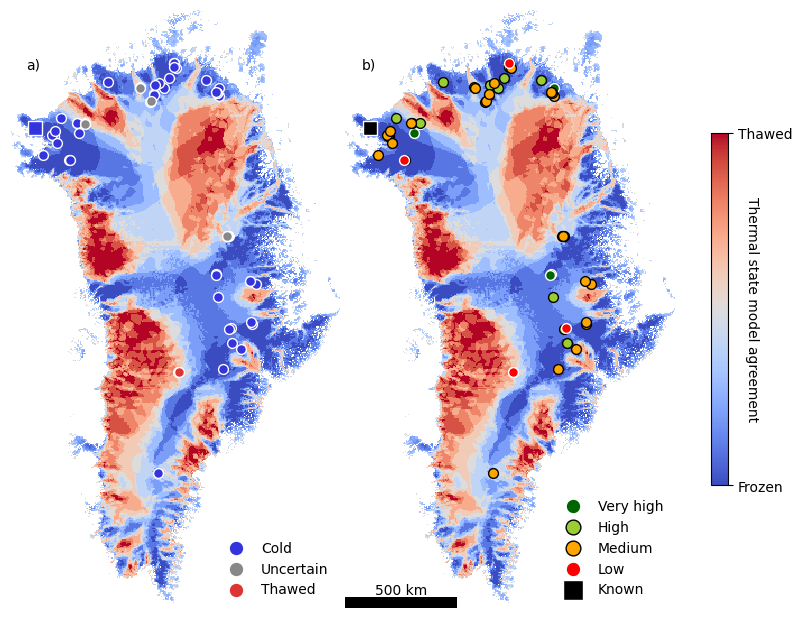

In [20]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = GridSpec(3, 4, left=0., right=0.9, bottom=0.0, top=1.,
    wspace=0.0, width_ratios=(100, 100, 10, 5), height_ratios=(25, 100, 25))
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])
axs = np.array([ax1, ax2])
cax = fig.add_subplot(gs[1,3])

[xx,yy] = np.meshgrid(x,y)
pc = ax1.pcolormesh(xx, yy, (agreement)/10, cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_aspect('equal')

cb = fig.colorbar(pc, cax=cax)
cb.set_label('Thermal state model agreement', labelpad=-24, rotation=-90)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Frozen', 'Thawed'])

BasalTemp_colors = {
    'Thawed':'#dd3434',
    'Uncertain':'#888888',
    'Cold':'#3434dd'}

lakes_categories = ['Cold', 'Uncertain', 'Thawed']
for category in lakes_categories:
    RES_subset = RES_only_lakes.where(RES_only_lakes['Tm_cat']==category)
    ax1.scatter(RES_subset['x'], RES_subset['y'], size['RES_only'],
               color=BasalTemp_colors[category], edgecolor='w', linewidth=1, label=category,
               marker=markers['RES_only'])
    
    seismic_subset = seismic_lakes.where(seismic_lakes['Tm_cat']==category)
    ax1.scatter(seismic_subset['x'], seismic_subset['y'], size['seismic'],
               color=BasalTemp_colors[category], edgecolor='w', linewidth=1,
               marker=markers['seismic'])


ax1.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.legend(loc='lower right', frameon=False, markerscale=1.5)
ax1.set_xlim([min(x), max(x)])

ax1.text(0.05, 0.9, 'a)', transform=ax1.transAxes)

pc = ax2.pcolormesh(xx, yy, (agreement)/10, cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_aspect('equal')

BasalTemp_colors = {
    'Thawed':'#dd3434',
    'Uncertain':'#888888',
    'Cold':'#3434dd'}

conf_colors = {'Low':'red',
              'Medium':'orange',
              'High':'yellowgreen',
               'Very high': 'darkgreen',
              '':'k'}

conf_lc = {'Low':'w', 'Medium':'k', 'High':'k', 'Very high':'w', '':'k'}

legend = {'Low':0, 'Medium':1, 'High':2, 'Very high':3}

lakes_categories = ['Very high', 'High', 'Medium', 'Low', '']
for category in lakes_categories:
    RES_subset = RES_only_lakes.where(RES_only_lakes['confidence']==category)
    ax2.scatter(RES_subset['x'], RES_subset['y'], size['RES_only'],
               color=conf_colors[category], edgecolor=conf_lc[category], linewidth=1, label=category,
               marker=markers['RES_only'])
    
    seismic_subset = seismic_lakes.where(seismic_lakes['confidence']==category)
    label = 'Known' if category=='' else None
    ax2.scatter(seismic_subset['x'], seismic_subset['y'], size['seismic'],
               color=conf_colors[category], edgecolor='w', linewidth=1,
               marker=markers['seismic'], label=label)


ax2.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.legend(loc='lower right', frameon=False, markerscale=1.5)
ax2.text(0.05, 0.9, 'b)', transform=ax2.transAxes)

xmin = min(x)
ymin = min(y)
scale_width = 500e3
scale_height = 0.1*scale_width
scalebar = patches.Rectangle((xmin, ymin), scale_width, scale_height, facecolor='k')
ax2.add_patch(scalebar)
ax2.text(xmin + 0.5*scale_width, ymin + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')
ax2.set_xlim([min(x), max(x)])

fig.savefig('greenland_thermal_lakes_merged_cat_conf.png', dpi=600)

In [21]:
print(seismic_lakes['x'], seismic_lakes['y'])

1   -517738.504199
Name: x, dtype: float64 1   -1.196769e+06
Name: y, dtype: float64


### What is the relationship between the B19 classification and basal thermal state?

Not much, model consensus is majority cold for all confidence levels


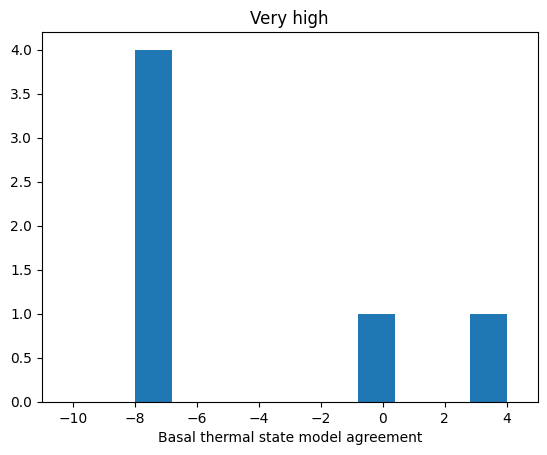

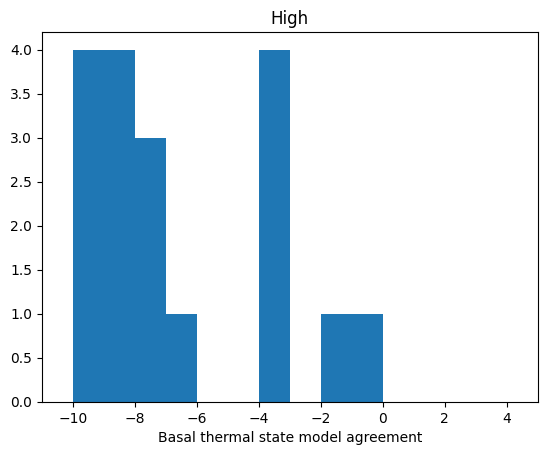

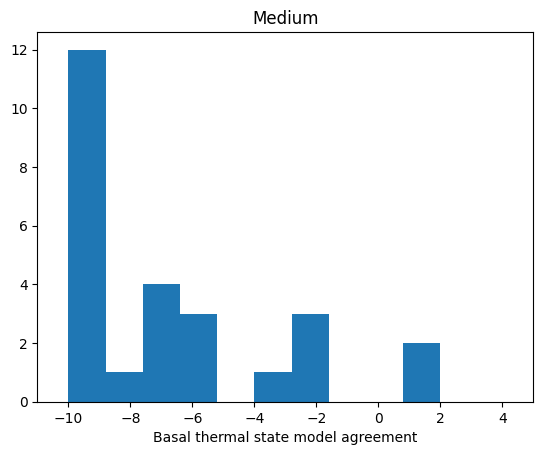

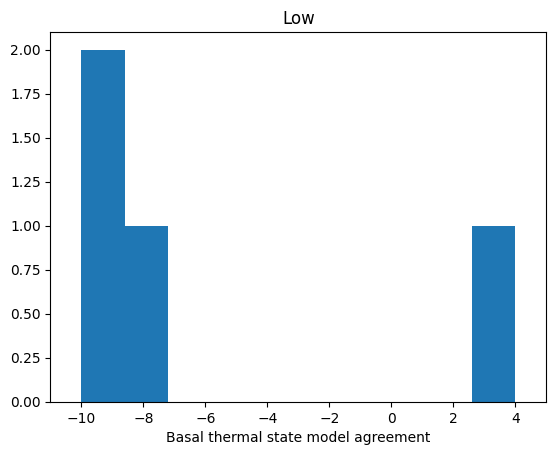

In [22]:
lakes_categories = ['Very high', 'High', 'Medium', 'Low']

for cat in lakes_categories:
    
    fig, ax = plt.subplots(facecolor='w')
    subset = RES_only_lakes[RES_only_lakes['confidence']==cat]
    ax.hist(subset['Agreement'], alpha=1)
    ax.set_title(cat)
    ax.set_xlim([-11, 5])
    ax.set_xlabel('Basal thermal state model agreement')